# Задание
* Скачать все вакансии СБЕРа с ХХ (у апи есть ограничение в 2000, а также captcha подумайте как их можно обойти) +
* Извлеките все описания этих вакансий +
* Создайте аналогичный vacancy DataFrame только добавьте поле skills
* Переведите даты публикаций в datetime
* Постройте график опубликованных вакансий по датам
* Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий
* Найдите те вакансии с использованием python, которые вам интересны
* Определите по полю skills какие навыки больше всего востребованы для этих вакансий
* Постройте график наиболее востребованных навыков для аналитика данных

https://github.com/hhru/api

In [1]:
import requests
import json
from tqdm.auto import tqdm
from collections import defaultdict
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [3]:
sber = 3529
num_per_page = 100
moscow = 1
page = 1
url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={page}&per_page={num_per_page}&area={moscow}'

In [4]:
num_pages = requests.get(url).json().get('pages')
num_pages

13

In [12]:
all_vacancy_ids= []
for page in tqdm(range(num_pages)):
    url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={page}&per_page={num_per_page}&area={moscow}'
    res = requests.get(url)
    vacancies = res.json()
    vacancy_ids = [el.get('id') for el in vacancies.get('items')]
    all_vacancy_ids.extend(vacancy_ids)
len(all_vacancy_ids)

  0%|          | 0/13 [00:00<?, ?it/s]

1268

In [35]:
# Извлеките все описания этих вакансий
# Создайте аналогичный vacancy DataFrame только добавьте поле skills
df = pd.DataFrame()
columns = ['id', 'created_at', 'name', 'description', 'key_skills']
test_id = list(pd.Series(all_vacancy_ids).sample(100)) #100 случайных id для тестов
for n in tqdm(test_id):  #all_vacancy_ids
    url_id = f'https://api.hh.ru/vacancies/{n}'
    res = requests.get(url_id).json()
    df_ = pd.json_normalize(res)[columns]
    df = pd.concat([df, df_], axis=0)
    #dict_id_desc[n] = res_id.json().get('description')
df.reset_index(drop=True)
df.info()

  0%|          | 0/100 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 0
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           100 non-null    object
 1   created_at   100 non-null    object
 2   name         100 non-null    object
 3   description  100 non-null    object
 4   key_skills   100 non-null    object
dtypes: object(5)
memory usage: 4.7+ KB


In [36]:
# Переведите даты публикаций в datetime
df['created_at'] = df['created_at'].astype('datetime64[ns]')
df['created_date'] = df['created_at'].dt.strftime('%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 0
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            100 non-null    object        
 1   created_at    100 non-null    datetime64[ns]
 2   name          100 non-null    object        
 3   description   100 non-null    object        
 4   key_skills    100 non-null    object        
 5   created_date  100 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 5.5+ KB


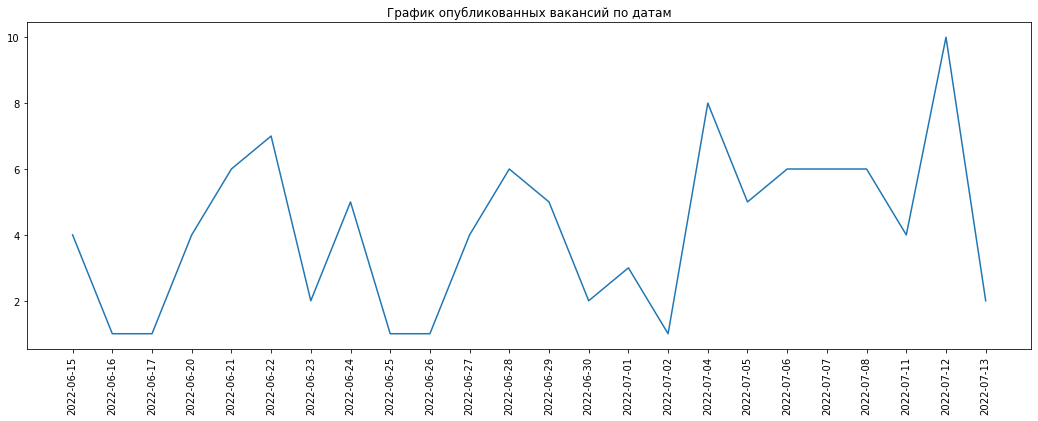

In [37]:
# Постройте график опубликованных вакансий по датам
for_gr = df.groupby('created_date').count()['id']
plt.figure(figsize=(18, 6))
plt.plot(for_gr)
plt.xticks(rotation = 90)
plt.title('График опубликованных вакансий по датам')
plt.show()

In [57]:
# Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий
df['dayofweek'] = df['created_at'].dt.dayofweek
days_map = {0:'понедельник', 1:'вторник', 2:'среда', 3:'четверг', 4:'пятница', 5:'суббота', 6:'воскресенье'}
df['dayofweek'] = df['dayofweek'].map(days_map)
print(f'Самый популярный день для публикаций вакансий - {df.dayofweek.value_counts().idxmax()}')

Самый популярный день для публикаций вакансий - вторник


In [79]:
# Найдите те вакансии с использованием python, которые вам интересны
cond1 = df.description.str.match('.*python.*', case=False)
cond2 = df.name.str.match('.*data.*', case=False)
cond3 = df.name.str.match('.*anal.*', case=False)
cond4 = df.name.str.match('.*аналит.*', case=False)
cond5 = df.name.str.match('.*данн.*', case=False)
df_da = df[(cond2&cond3) | (cond4&cond5)] #фрейм аналитиков данных
df_like = df[cond1&(cond2|cond3)] # фрейм с вакансиями, которые интересны
df_like.name

0    Data Engineer в Лабораторию Нейронаук и поведения человека
0                                     Lead Data Scientist ML/CV
0                      Data Analyst / Data Engineer (Биометрия)
0                                                 Data Engineer
0                                         Senior Data Scientist
0                        Системный аналитик (аналитик Big Data)
0        QA Engineer, Big Data (инженер по тестированию данных)
0                    Инженер по сопровождению Hadoop (SberData)
Name: name, dtype: object

In [80]:
# Определите по полю skills какие навыки больше всего востребованы для этих вакансий

def skills(obj, n): # n - число, меньше которого навыки не показывать
    l = []
    for skills in obj.key_skills:
        for skill in skills:
            l.append(skill.get('name'))
    skills_for_gr = pd.Series(l).value_counts()
    return skills_for_gr[skills_for_gr>n]

skills(df_like, 2)

Python    5
SQL       3
Spark     3
dtype: int64

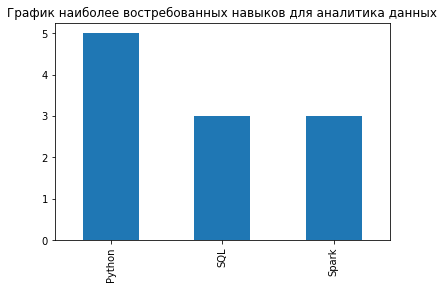

In [89]:
# Постройте график наиболее востребованных навыков для аналитика данных
sk = skills(df_like, 2)
sk.plot.bar()
plt.title('График наиболее востребованных навыков для аналитика данных')
plt.show()